In [1]:
"""

1) load in dataframe
    -> Of importance : this contains the label (Family), FilePath, and View (of image taken)
2) dataframe filtered for DORSAL view
3) train-test-split with even numbers of each class
4) visualize dataset + image augmentation
5) make model
6) add loss, callbacks, class weights, etc...
7) train model
8) check model performance

"""

'\n\n1) load in dataframe\n    -> Of importance : this contains the label (Family), FilePath, and View (of image taken)\n2) dataframe filtered for DORSAL view\n3) train-test-split with even numbers of each class\n4) visualize dataset + image augmentation\n5) make model\n6) add loss, callbacks, class weights, etc...\n7) train model\n8) check model performance\n\n'

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

In [3]:
#NOTE - I am working in an nvidia-docker image with official tensorflow docker.
# I had to add this line AND 'trust' the notebook on top-right. Otherwise an ugly
# cudNN error is present.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
image_dir = '/home/jovyan/work/beetleData/images/'
label_csv = '/home/jovyan/work/beetleData/labels/master_rbi.csv'

In [5]:
labels = pd.read_csv(label_csv)
labels.head()

,Family:,Subfamily:,Country:,Province:,Genus:,Species:,View:,Filename:
0,Anthribidae,/,Equatorial Guinea,/,Phaeotragus,gigas,Dorsal,rbi_1.jpg
1,Anthribidae,/,Equatorial Guinea,/,Phaeotragus,gigas,Lateral,rbi_2.jpg
2,Anthribidae,/,Madagascar,/,Tophroderes,phrenatus,Dorsal,rbi_3.jpg
3,Brentidae,/,Indonesia,Sumatra,Eutrachelus,temmincki,Dorsal,rbi_4.jpg
4,Brentidae,/,Indonesia,Sumatra,Eutrachelus,temmincki,Dorsal,rbi_5.jpg


<AxesSubplot:>

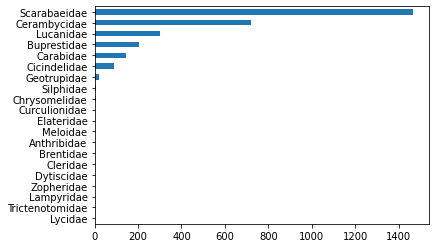

In [6]:
classify_column = 'Family:'

dorsal_data = labels[labels["View:"] == "Dorsal"] #filter images that are from dorsal view
dorsal_data[classify_column].value_counts().sort_values().plot(kind = 'barh') # preview the distribution

In [7]:
top_classes = 6
top6 = dorsal_data[classify_column].value_counts(normalize=True)[:top_classes]
top6

Scarabaeidae    0.492287
Cerambycidae    0.241449
Lucanidae       0.100604
Buprestidae     0.069081
Carabidae       0.048625
Cicindelidae    0.030181
Name: Family:, dtype: float64

<AxesSubplot:>

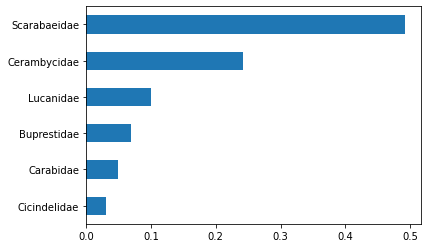

In [8]:
top6.sort_values().plot(kind = 'barh') # preview the distribution

In [9]:
print(top6)
print(top6.index)

Scarabaeidae    0.492287
Cerambycidae    0.241449
Lucanidae       0.100604
Buprestidae     0.069081
Carabidae       0.048625
Cicindelidae    0.030181
Name: Family:, dtype: float64
Index(['Scarabaeidae', 'Cerambycidae', 'Lucanidae', 'Buprestidae', 'Carabidae',
       'Cicindelidae'],
      dtype='object')


In [10]:
top6_df = dorsal_data[dorsal_data[classify_column].isin(list(top6.index))] #filter images from only top 6 classes
top6_df.tail()

,Family:,Subfamily:,Country:,Province:,Genus:,Species:,View:,Filename:
4057,Scarabaeidae,Scarabaeinae,Central African Republic,Haute-Sangha,Sisyphus,atratus,Dorsal,rbi_4233.jpg
4058,Scarabaeidae,Scarabaeinae,CÃ´te d'Ivoire,/,Sisyphus,biarmatus,Dorsal,rbi_4234.jpg
4059,Scarabaeidae,Scarabaeinae,Central African Republic,KÃ©mo,Sisyphus,gladiator,Dorsal,rbi_4235.jpg
4060,Scarabaeidae,Scarabaeinae,Central African Republic,KÃ©mo,Sisyphus,gladiator,Dorsal,rbi_4236.jpg
4061,Scarabaeidae,Scarabaeinae,/,/,Sisyphus,muricatus,Dorsal,rbi_4237.jpg


In [11]:
"""
train_test_splitter_even_across_labels

a function which takes a dataframe of data points, goes through each unique value in the label, and
randomly samples % for train/test split
"""
train_indexes = []
test_indexes = []
train_ratio = 0.8 # ****** IMPORTANT PARAMETER
get_labels = top6_df[classify_column].unique()
# loop through each label
count = 0
for label_type in get_labels:
    print(label_type)
    #subset the whole dataframe for the label_type
    subset_df = top6_df[top6_df[classify_column] == label_type]
    #split the rows randomly into a subset_test and subset_train dataframe
    number_samples = subset_df.shape[0] #total number of rows in dataframe
    df_split = pd.DataFrame(np.random.randn(number_samples,2))
    df_split = np.random.rand(len(df_split)) < train_ratio
    train = list(subset_df[df_split].index)
    test = list(subset_df[~df_split].index)
    train_indexes.append(list(train))
    test_indexes.append(list(test))
    
train_indexes = [item for sublist in train_indexes for item in sublist] # fancy way to flatten a list of lists
test_indexes = [item for sublist in test_indexes for item in sublist]

train_dataframe = top6_df.iloc[top6_df.index.isin(train_indexes)] # fancy way to subset a dataframe by list of indexes
test_dataframe = top6_df.iloc[top6_df.index.isin(test_indexes)]

Buprestidae
Carabidae
Cerambycidae
Cicindelidae
Lucanidae
Scarabaeidae


In [13]:
#important parameters
image_size = (128,128)
batch_size = 24

In [14]:
datagen=ImageDataGenerator(rescale=1./255)
classes = list(train_dataframe["Family:"].unique())
train_generator=datagen.flow_from_dataframe(dataframe=train_dataframe,
                                        directory=image_dir,
                                        x_col="Filename:", y_col="Family:",
                                        class_mode="categorical",
                                        classes = classes,
                                        target_size=image_size,
                                        batch_size=batch_size)

test_generator=datagen.flow_from_dataframe(dataframe=test_dataframe,
                                        directory=image_dir,
                                        x_col="Filename:", y_col="Family:",
                                        class_mode="categorical",
                                        classes = classes,
                                        target_size=image_size,
                                        batch_size=batch_size)

Found 2341 validated image filenames belonging to 6 classes.
Found 588 validated image filenames belonging to 6 classes.


In [15]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

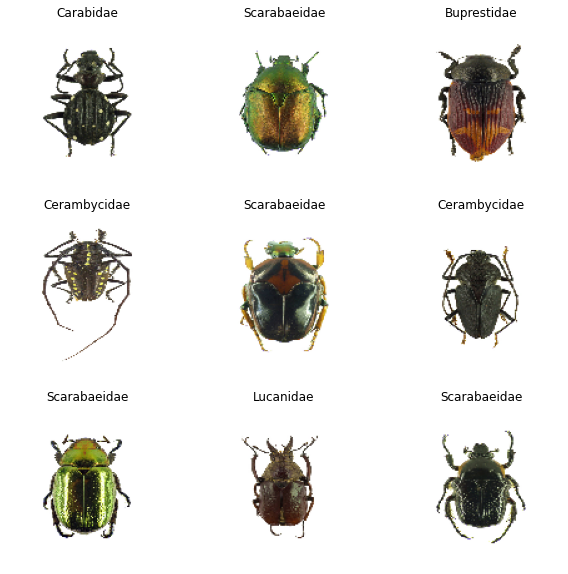

In [16]:
# Preview Dataset
plt.figure(figsize=(10, 10))
img,label=test_generator.next()
for i in np.arange(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i])
    plt.title(classes[np.argmax(label[i])])
    plt.axis('off')

In [17]:
augmented_image = data_augmentation(img)

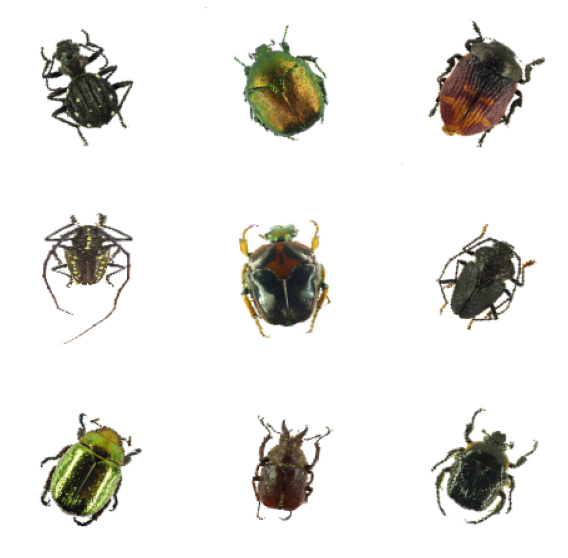

In [18]:
# Preview a batch of image augmentations
plt.figure(figsize=(10, 10))
img,label=test_generator.next()
for i in np.arange(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i])
    plt.axis('off')

In [19]:
# this model is taken from https://keras.io/examples/vision/image_classification_from_scratch/

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
keras.utils.plot_model(model, show_shapes=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
filepath = !pwd
filepath = filepath[0] + '/models/'
print(filepath)

/home/jovyan/work/github/beetle-vision/models/


In [21]:
# CALLBACKS : This will determine which models are saved during training.

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath + "save_at_{epoch}.h5",
                                   monitor='val_accuracy',
                                   save_best_only=True),
]

In [22]:
# LOSS FUNCTION
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=.10,
    reduction="auto",
    name="categorical_crossentropy",
)

In [23]:
# CLASS WEIGHTS : This is an imbalanced dataset so this should be (theoretically) crucial
#cool trick to automatically generate the relative weights to make the classes appear balanced.
    #https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
    
from sklearn.utils import class_weight
y_train = train_generator.classes
c_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             np.array(y_train))
class_weight_dict = dict(enumerate(c_weights))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[0 0 0 ... 5 5 5] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [24]:
epochs = 30

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=["accuracy"],
)
history = model.fit(
    train_generator, epochs=epochs, callbacks=callbacks, validation_data=test_generator,class_weight=class_weight_dict
)

Epoch 1/30
98/98 [==============================] - 19s 140ms/step - loss: 1.4572 - accuracy: 0.4922 - val_loss: 1.7918 - val_accuracy: 0.0646
Epoch 2/30
98/98 [==============================] - 12s 119ms/step - loss: 0.9547 - accuracy: 0.7769 - val_loss: 2.4158 - val_accuracy: 0.0646
Epoch 3/30
98/98 [==============================] - 13s 130ms/step - loss: 0.7609 - accuracy: 0.8631 - val_loss: 3.8788 - val_accuracy: 0.0646
Epoch 4/30
98/98 [==============================] - 13s 128ms/step - loss: 0.7699 - accuracy: 0.8928 - val_loss: 4.9485 - val_accuracy: 0.0646
Epoch 5/30
98/98 [==============================] - 12s 117ms/step - loss: 0.6316 - accuracy: 0.9249 - val_loss: 3.8403 - val_accuracy: 0.0680
Epoch 6/30
98/98 [==============================] - 12s 117ms/step - loss: 0.6548 - accuracy: 0.9310 - val_loss: 1.4366 - val_accuracy: 0.6735
Epoch 7/30
98/98 [==============================] - 12s 120ms/step - loss: 0.6181 - accuracy: 0.9462 - val_loss: 1.0563 - val_accuracy: 0.6769

In [ ]:
test_generator.filepaths[10]
test_generator.classes[10]

In [25]:
img = keras.preprocessing.image.load_img(
    test_generator.filepaths[10], target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

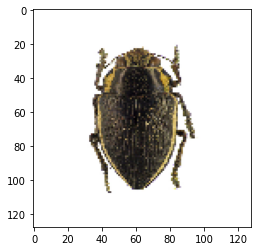

In [26]:
plt.imshow(img)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict(test_generator)

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
cm = (confusion_matrix(test_generator.classes, Y_pred))

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    from https://deeplizard.com/learn/video/km7pxKy4UHU
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
plot_confusion_matrix(cm, classes)

In [ ]:
print('Classification Report')
target_names =classes
print(classification_report(test_generator.classes, Y_pred, target_names=target_names))